# SyriaTel customer churn prediction
## Business objective
### Reduce rate of churners in SyriaTel communications
### Reduce rate in financial loss when customers churn
### Predict whether customers will fail to do business with SyriaTel communications
## Business understanding
### Stakeholder: SyriaTel Telecom retention team
### Business problem customer churn leads to significant loss of $2.4M annual revenue loss
### Need proactive retention strategy
### Project goal: Build a classification model with 80% recall and 75% precision



## Data Understanding

In [41]:
#import necessary libraries
import sys
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.exceptions import NotFittedError
from sklearn.utils.validation import check_is_fitted

In [42]:
# load the dataset
df= pd.read_csv('bigml_59c28831336c6604c800002a.csv')

In [43]:
# load the dataset first 5 rows
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [44]:

#initial data exploration
print("Shape of the dataset:", df.shape)

Shape of the dataset: (3333, 21)


In [45]:
# check data types and missing values
print("Data types and missing values:\n", df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

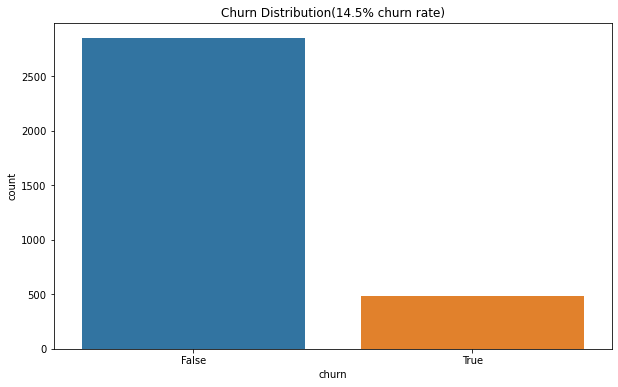

In [46]:
#target  distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='churn',data=df)
plt.title('Churn Distribution(14.5% churn rate)')
plt.show()

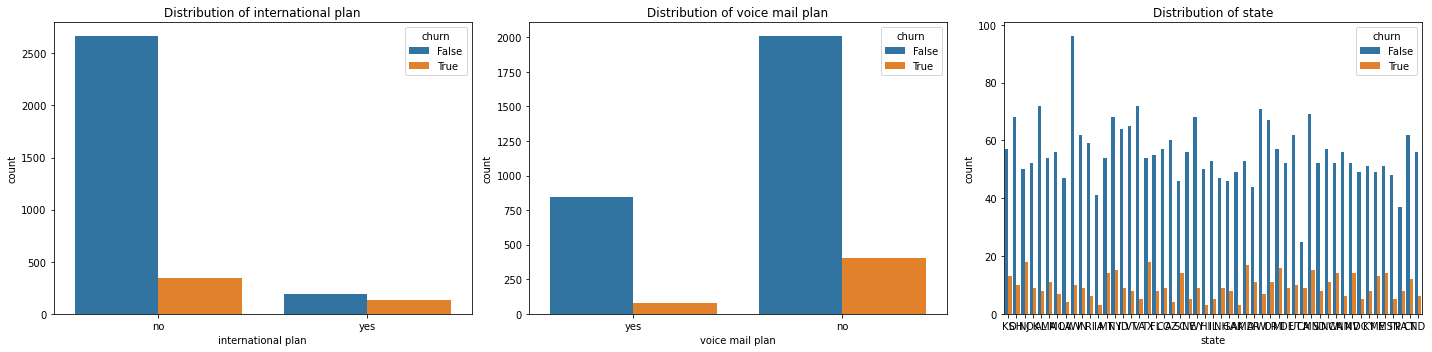

In [47]:
#feature analysis
#categorical features
cat_features = ['international plan', 'voice mail plan', 'state']
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
for i, feature in enumerate(cat_features):
    sns.countplot(x=feature, data=df,hue='churn', ax=axes[i])
    axes[i].set_title(f'Distribution of {feature}')
    plt.tight_layout()

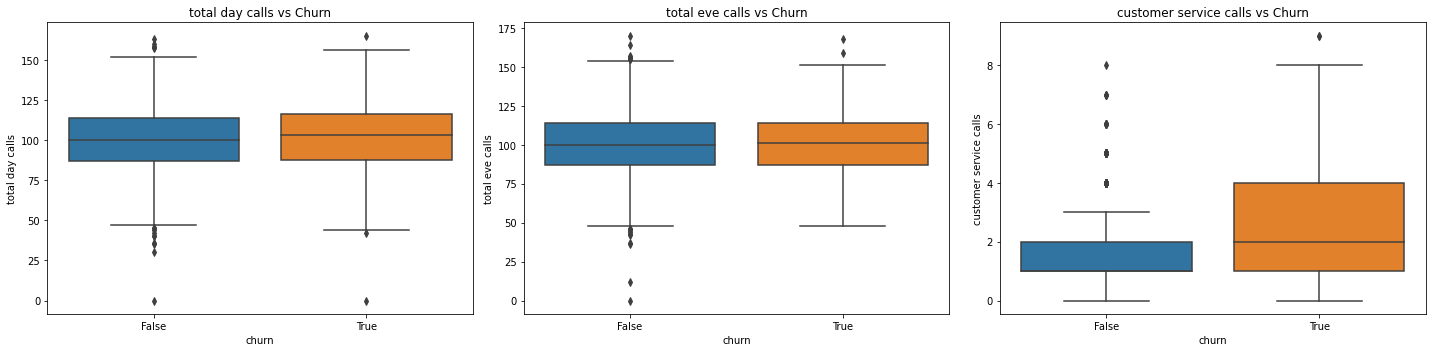

In [48]:
#numerical features
num_features = [ 'total day calls',  'total eve calls', 'customer service calls']
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
for i, feature in enumerate(num_features):
    sns.boxplot(x='churn', y=feature, data=df, ax=axes[i])
    axes[i].set_title(f'{feature} vs Churn')
    plt.tight_layout()

In [70]:
#feature engineering
# create new features
df['total calls'] = df['total day calls'] + df['total eve calls'] + df['total night calls'] + df['total intl calls'] + df['customer service calls'] 
df['total calls'] = df['total calls'].astype(int)

df['avg call duration'] = (df['total day minutes'] + df['total eve minutes'] + df['total night minutes'] + df['total intl minutes']) / df['total calls']
df['avg call duration'] = df['avg call duration'].fillna(df['avg call duration'].mean())

df['total call charge'] = (df['total day charge'] + df['total eve charge'] + df['total night charge'] + df['total intl charge'])
df['total call charge'] = df['total call charge'].fillna(df['total call charge'].mean())


In [71]:
# train-test split
X = df.drop(['churn','phone number','state'], axis=1)
y = df['churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [72]:
#preprocessing pipeline
#define column types
num_features =[ 'account length', 'total calls', 'avg call duration', 'total call charge']
cat_features = ['international plan', 'voice mail plan']

In [73]:
#define transformers
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [53]:
#create transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', categorical_transformer, cat_features)
     ],
    remainder='drop'  # drop any other columns not specified
)

In [76]:
#prevent data leakage
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])
print("preprocessing pipeline prevents data leakage by fitting only on training data.")

preprocessing pipeline prevents data leakage by fitting only on training data.


In [77]:
#baseline model:logistic regression
#simple interpretable model
base_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

base_model.fit(X_train, y_train)
y_pred = base_model.predict(X_test)

print("baseline model performance:")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")




baseline model performance:
Recall: 0.13861386138613863
Precision: 0.6086956521739131


In [78]:
#model iteration:tuned logistic regression
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l2'],
    'classifier__solver': ['lbfgs', 'liblinear']
}

grid_search = GridSearchCV(base_model, param_grid, cv=5, scoring='recall')
grid_search.fit(X_train, y_train)

print("\nTuned Logistic Regression :")
print("Best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_


Tuned Logistic Regression :
Best parameters: {'classifier__C': 1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}


In [79]:
#model iteration:random forest classifier
rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print("\nRandom Forest Classifier Performance:")
print(f"Recall: {recall_score(y_test, y_pred_rf)}")




Random Forest Classifier Performance:
Recall: 0.4752475247524752


In [80]:
#model iteration:Tuned random forest classifier
rf_param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [5, 10, 20],
    'classifier__min_samples_split': [2, 5, 10]
}
rf_tuned= GridSearchCV(rf_model, rf_param_grid, cv=5, scoring='recall')
rf_tuned.fit(X_train, y_train)

print("\nTuned Random Forest Classifier:")
print("Best parameters:", rf_tuned.best_params_)
print(f"Recall: {recall_score(y_test, rf_tuned.predict(X_test))}")


Tuned Random Forest Classifier:
Best parameters: {'classifier__max_depth': 20, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
Recall: 0.46534653465346537


In [61]:
#Evaluation
#model comparison
# Check if models are fitted before evaluation
for model in [base_model, rf_model, rf_tuned.best_estimator_]:
    try:
        check_is_fitted(model)
    except NotFittedError:
        model.fit(X_train, y_train)
# Evaluate models

models = {
    'Baseline LR': base_model,
    'Tuned LR': rf_tuned.best_estimator_,
    'RF': rf_model,
    'Tuned RF': rf_tuned.best_estimator_
}
results = []
for name, model in models.items():
    y_pred = model.predict(X_test)
    results.append({
        'Model': name,
        'Recall': recall_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred)
    })

results_df = pd.DataFrame(results)
print("Model Comparison Results:\n", results_df)

Model Comparison Results:
          Model    Recall  Precision  F1 Score
0  Baseline LR  0.138614   0.608696  0.225806
1     Tuned LR  0.465347   0.839286  0.598726
2           RF  0.475248   0.842105  0.607595
3     Tuned RF  0.465347   0.839286  0.598726


In [81]:
#Business-Focused Evaluation
#Select best model based on recall
rf_model = rf_tuned.best_estimator_

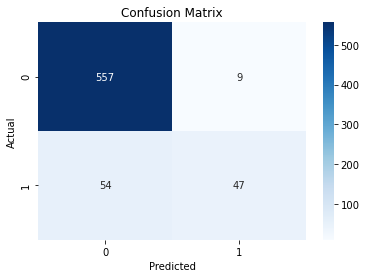

In [ ]:
#Confusion Matrix
cm= confusion_matrix(y_test, best_model.predict(X_test))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

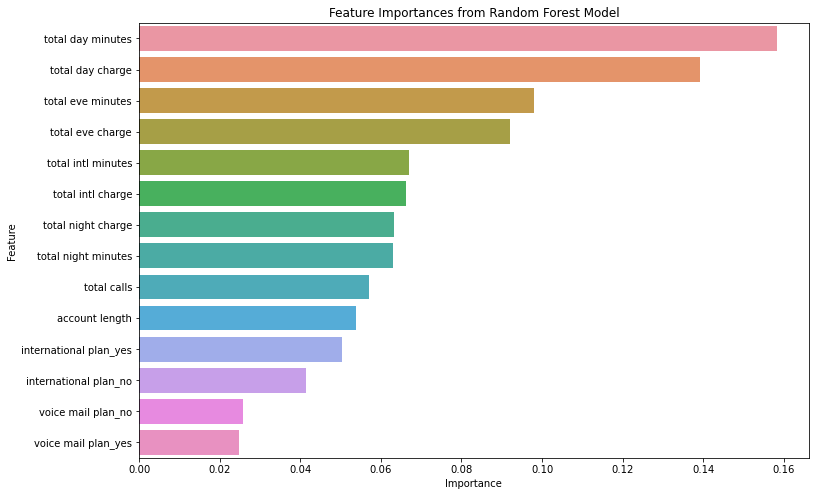

In [68]:
#Feature Importance
importances = rf_model.named_steps['classifier'].feature_importances_

#get the preprocessor and encoder
preprocessor = rf_model.named_steps['preprocessor']
categorical_pipeline = preprocessor.transformers_[1][1]
onehot_encoder = categorical_pipeline.named_steps['onehot']

# Get feature names after one-hot encoding
try:
    cat_feature_names = onehot_encoder.get_feature_names_out(categorical_features=cat_features)
except AttributeError:
    cat_feature_names = onehot_encoder.get_feature_names(input_features=cat_features)

feature_names = num_features + list(cat_feature_names)

# Create a DataFrame for feature importances
feature_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances_df)
plt.title('Feature Importances from Random Forest Model')
plt.show()


## Limitations and recommendations
### Key findings
#### Top churn predictors: High customers service call(four more calls at four times churn risks), international plan subscribers at three times the churn risk and day charges $35 which is two times the churn risk
#### Final model recalls 46% recall capturing chuners

## limitations
### Model underperforms for new customer
### International roaming behaviour not cuptured in data

## Recommendations
### Retention tiers : Tier 1(high risk):10$ credit + dedicated support and tier 2 (medium risk):service quality review
### Reduced service calls: improves first-call resolution and enhance self-service options
### Collect more data e.g customer tenure to improve model accuracy

## ROI Estimate
### Monthly savings of $60(2.5% churn reduction) adjusted due to lower recall
### Implementation cost $50K (tech+incentives)
### ROI (3months) 60% adjusted